In [704]:
pip install torch

     |████████████████████████████████| 150.8 MB 60 kB/s  eta 0:00:01   |█▌                              | 7.2 MB 6.3 MB/s eta 0:00:23     |████████▊                       | 41.2 MB 6.5 MB/s eta 0:00:17     |█████████                       | 41.9 MB 6.5 MB/s eta 0:00:17     |████████████▋                   | 59.2 MB 4.8 MB/s eta 0:00:20     |████████████▊                   | 59.8 MB 4.8 MB/s eta 0:00:19     |█████████████▌                  | 63.4 MB 4.7 MB/s eta 0:00:19     |██████████████████████▎         | 105.0 MB 3.0 MB/s eta 0:00:16     |█████████████████████████▍      | 119.5 MB 5.6 MB/s eta 0:00:06     |████████████████████████████▌   | 134.1 MB 5.2 MB/s eta 0:00:04     |█████████████████████████████▊  | 140.0 MB 9.1 MB/s eta 0:00:02
Note: you may need to restart the kernel to use updated packages.


In [705]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import torch

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal
from scipy.stats import norm
import seaborn as sns

# Density Evaluation with more precision
from torch.distributions.multivariate_normal import MultivariateNormal

## Autograd packages

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence
import ot #Optimal Transport


## Import functions for the experiment : 

from experiment_functions import *
from IPLA_Exp_Functions import *


In this experiment, we consider a Parametric latent variable models (LVM) in a specific setting. In this context, we will be able to do a fair comparison between several algorithms that aim to estimate the Maximum Marginal Likelihood of the model. 
\\ \\
Let us consider a generic latent variable model as $p_\theta(x,y)$, parameterised by $\theta \in \mathbb{R}^{d_\theta}$, for fixed data $y \in \mathbb{R}^{d_y}$, and latent variables $x \in \mathbb{R}^{d_x}$. This model is considered for fixed observed data $y$, thus formally we see the statistical model as a real-valued mapping $p_\theta(x,y) : \mathbb{R}^{d_x} \times \mathbb{R}^{d_\theta} \rightarrow \mathbb{R}$. The task we are interested in is to estimate the parameter $\theta$ that explains the fixed dataset $y$. Often, this task is achieved via the maximum likelihood estimation (MLE). In accordance with this, in our setting, due to the presence of latent variables, we aim at finding the maximum marginal likelihood estimate (MMLE), more precisely, our problem takes the form

\begin{equation}
\theta^\ast \in \arg \max_{\theta \in \mathbb{R}^{d_\theta}} \log p_\theta(y),
\end{equation}

where $p_\theta(y) := \int p_\theta(x,y) \, dx$ is the marginal likelihood.
\\ 
The main difficulty is that, very often, this integral is intractable. This is where the different algorithms studied appear. 
\\ \\
With the notation $U(\theta, x) = -\log p_\theta(x,y)$, the $\theta$-gradient of $\log p_\theta(y)$ is given as

\begin{equation}
\nabla_\theta \log p_\theta(y) = - \frac{\int \nabla_\theta U(\theta, x) p_\theta(x, y) \, dx}{p_\theta(y)} = - \int \nabla_\theta U(\theta, x) p_\theta(x \mid y) \, dx,
\end{equation}



In this experiment, we consider the following Latent Variable Model: 

- $\mathbf{y} = \theta^{*}\mathbf{x} + \mathbf{z}$ where:
- $\mathbf{y} \in \mathbb{R}$ is the observed data,
- $\theta^{*} \in \mathbb{R}^{2}$ is the "ground truth" parameter that links the latent variables and the observed data.

To generate $\mathbf{y}$, the observed data, we first draw $x^{*} \sim p_{0}$ and set $\mathbf{y} := \theta^{*}x + \mathbf{z}$, where $\mathbf{z} \sim \mathcal{N}(0, \sigma_y^{2})$ 

For a given dimension $d_x$, we consider the prior distribution $p_0$, which is a mixture of 25 Gaussian random variables. The components have mean $\mu_{i,j} := (8i, 8j, \ldots, 8i, 8j) \in \mathbb{R}^{d_x}$ for $(i, j) \in \{-2, -1, 0, 1, 2\}^2$ and unit variance. We have set the associated unnormalized weights $\omega_{i,j} = 1.0$. This choice of Parametric Model is convenient because it allows the Posterior Distribution to stay in the same parametric family of distribution : it is a Gaussian Mixture. 

The joint density of the variables, $ p_\theta(x, y) $, is given by : $ p_\theta(x, y) = p_\theta(y \mid x) p_{0}(x) $, where : 
- $ p_\theta(y \mid x) = \mathcal{N}(y \mid \theta^{*}x, \sigma_y^2)$
- $ p_{0}(x) = \frac{1}{K} \sum_{k=1}^K \mathcal{N}(x \mid \mu_k, I) $

Then, given the log-densities of the conditional log-likelihood of the observed data $y$ and of the prior distribution : 

$\log \mathcal{N}(y \mid \theta x, \sigma_y^2) = -\frac{1}{2} \log(2\pi \sigma_y^2) - \frac{1}{2\sigma_y^2} (y - \theta x)^T (y - \theta x)$

$\log p_{\mathbf{0}}(x) = \log \left( \frac{1}{K} \sum_{k=1}^K \mathcal{N}(x \mid \mu_k, I) \right)$

We are able to compute the gradient of $ p_\theta(x, y) $ with respect to the parameters $\theta$ and $x$ : 

\begin{equation}
\nabla_x \log p_{\theta}(x, y) = \frac{1}{\sigma_y^2} \theta^T (y - \theta x) + \sum_{k=1}^K \frac{\mathcal{N}(x \mid \mu_k, I)}{K p_{0}(x)} \left(- (x - \mu_k)\right)
\end{equation}

\begin{equation}
\nabla_{\theta} \log p_{\theta}(x, y) = \frac{1}{\sigma_y^2} (y - \theta x) x^T
\end{equation}


------------------------------------------------------------------------------------------------------------------------------------------
First, we define a function to generate the parameters of our prior distribution, given : 
- dx
- size of the hypercube that contains our modes

In [713]:
def gen_prior_param(dx, size_cube): 
    """
    Function to generate the parameters of the prior distribution of the experiment
    """
    
    semi_size = size_cube // 2
    range_values = np.array([-2, -1, 0, 1, 2])  # Values for i and j
    grid = np.array(np.meshgrid(range_values, range_values)).T.reshape(-1, 2)  

    means = []
    for (i, j) in grid:
        mean_vector = np.tile([semi_size*i, semi_size*j], dx // 2)  # Create a pattern 
        means.append(mean_vector)

    means_prior = np.array(means)

    # Verify the shape
    print("Shape of means array:", means_prior.shape)

    ## Covariance
    covariances_prior = np.array([np.eye(dx)] * 25)
    print(f"Unit Covariance Matrix: {covariances_prior[0]}")

    # Weights
    weights_prior = np.ones(25) / 25
    print(f'Weights vector : {weights_prior}')

    return means_prior, covariances_prior, weights_prior

In [714]:
params = gen_prior_param(80, 16)

Shape of means array: (25, 80)
Unit Covariance Matrix: [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Weights vector : [0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]


------------------------------------------------------------------------------------------------------------------------------------------
We generalize the function to sample from a Gaussian Mixture of dimension $dx$, given its parameters (means, covariances, weights)

In [641]:
def sample_prior_dx(nb_particle_gen, centers_prior, covariances_prior, weights_prior) : 
    """

    Function to sample from a Gaussian Mixture given its parameters (means, covariances and weights) and the wanted size of the sample. 
    In the context of the experiment, we use it to initialize the algorithm and to manually generate the observation Y

    """

    dx = centers_prior[0].shape[0]
    nb_components = len(weights_prior)

    x_star = np.zeros((nb_particle_gen, dx))

    # Selection of the component randomly
    component_choices = np.random.choice(nb_components, size=nb_particle_gen, p=weights_prior) #choix aléatoire entre les normales de la mixture (pondéré)

    for i in range(nb_components):

        num_samples = np.sum(component_choices == i) #

        if num_samples > 0:

            #x_star[component_choices == i] = np.random.multivariate_normal(mean=centers[i], cov=covariances[i], size=num_samples) #pour les indices où l'on a tiré la composante en question on tire selon celle-ci
            x_star[component_choices == i] = np.random.multivariate_normal(mean=centers_prior[i], cov=covariances_prior[i], size=num_samples) 

    return x_star

In [642]:
x_start = sample_prior_dx(1000, params[0], params[1], params[2])
x_start_2 = sample_prior_dx(1000, params[0], params[1], params[2])

------------------------------------------------------------------------------------------------------------------------------------------
We write a little function to plot the first 2 dimensions of two samples (max)

PS : In the article -> 1 sample drawn from the right distribution and another one from the approximation

In [643]:
def plot_sample_dx(sample_to_plot_1, desc_sample_1 = '', sample_to_plot_2=None, desc_sample_2 = ''): 

    sns.set(style="whitegrid")
    
    plt.figure(figsize=(10, 10))
    plt.scatter(sample_to_plot_1[:, 0], sample_to_plot_1[:, 1], alpha=0.6, s=50, color="red", label = desc_sample_1, edgecolor='k')
    
    if sample_to_plot_2 is not None: 

        plt.scatter(sample_to_plot_2[:, 0], sample_to_plot_2[:, 1], alpha=0.2, s=50, color=sns.color_palette("husl", 8)[2], label = desc_sample_2, edgecolor='k')
    
    plt.title('Sample from a Gaussian Mixture Distribution', fontsize=16, weight='bold')
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gca().set_facecolor('#f7f7f7')
    
    plt.legend()
    plt.show()
 

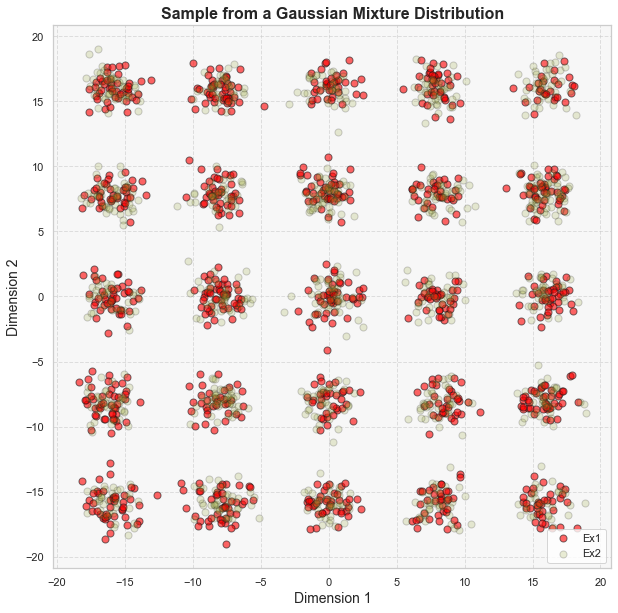

In [644]:
plot_sample_dx(x_start, desc_sample_1 = 'Ex1',sample_to_plot_2 = x_start_2, desc_sample_2 = "Ex2")


------------------------------------------------------------------------------------------------------------------------------------------
We generate the function to generate the initial $y_obs$ as in the article : 

To generate $\mathbf{y}$, the observed data, we first draw $x^{*} \sim p_{0}$ and set $\mathbf{y} := \theta^{*}x + \mathbf{z}$, where $\mathbf{z} \sim \mathcal{N}(0, \sigma_y^{2})$ 

In [645]:
def generate_obs_dx(x_star, theta, sigma_y) : 
     """
    
    Function that generates the observed data point as it is explained in the Appendix of the paper : y = Hx + z. 
    x is drawn according to the prior distribution and z is a gaussian noise whose parameters are defined in the Appendix. 

    """
    
     noise = np.random.normal(0, sigma_y**2)

     y_obs = np.dot(theta, x_star.T) + noise

     return y_obs

In [646]:
x_star = sample_prior_dx(1, params[0], params[1], params[2])
theta_star = np.random.uniform(0, 1, 80)

y_obs_dx = generate_obs_dx(x_star, theta_star, 0.1)
y_obs_dx

array([602.34952097])

------------------------------------------------------------------------------------------------------------------------------------------
We define the function that returns the parameters of the posterior Distribution (Gaussian Mixture), given the $\theta$ and the $y_{obs}$ that we have : 

In [647]:

def post_params_dx(theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs, plot = False):
    """
    
    In the context of this experiment, the posterior distribution is also a Gaussian Mixture whose parameters can be analytically computed. 
    This function permits to generates those parameters given the parameters of the model and of the prior distribution.  

    """

    dx = theta.shape[0]

    nb_components = weights_prior.shape[0]

    theta_reshape = theta.reshape(1, dx) #To behave as a matrix

    Sigma_post = np.linalg.inv(np.eye(dx) + (1 / sigma_y**2) * np.outer(theta_reshape.T, theta_reshape))

    covariances_posteriori = np.full((nb_components, dx, dx), Sigma_post)

    weights_posteriori = np.zeros(nb_components)

    centers_posteriori = np.zeros((nb_components, dx))

    for i in range(nb_components): 
        
        M = (theta * (y_obs / (sigma_y ** 2)))
        
        centers_posteriori[i] = np.dot(Sigma_post, M + centers_prior[i]) ## WTF OUBLI M ? 

        ## Weights
        mean_pdf = theta @ centers_prior[i].T

        covariance_pdf = sigma_y**2 + np.dot(theta_reshape, theta_reshape.T)
    
        weights_posteriori[i] = weights_prior[i] * norm.pdf(y_obs, mean_pdf, covariance_pdf)

    weights_posteriori = weights_posteriori / np.sum(weights_posteriori)

    return centers_posteriori, covariances_posteriori, weights_posteriori

In [648]:
theta_star = np.tile([-1, 1], 40)
#theta_star = np.tile(np.random.uniform(-4, 4, 40), 2)

No handles with labels found to put in legend.


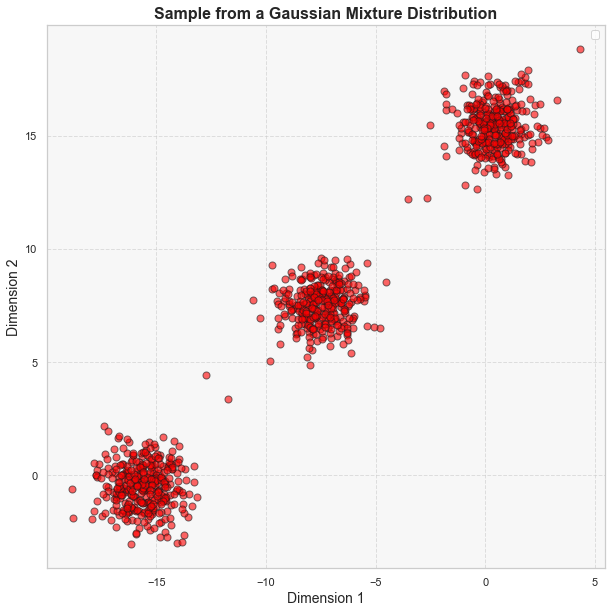

In [649]:
centers_posteriori, covariances_posteriori, weights_posteriori = post_params_dx(theta_star, 0.1, means_prior, covariances_prior, weights_prior, y_obs_dx)

sample_post = sample_prior_dx(1000, centers_posteriori, covariances_posteriori, weights_posteriori)
plot_sample_dx(sample_post)

------------------------------------------------------------------------------------------------------------------------------------------
Here we define the function that runs the Unadjusted Langevin Algorithm to intent to sample from the posterior distribution without knowing its exact parameters, but only having an oracle on the score vector : $\nabla_x p_\theta(x \mid y)$. 

It is a reasonable assumption because we know the posterior distribution up to a normalizing constant, it means that it doesn't affect the derivative of the log-density. 

In [ ]:
def ULA_post_dx(sample_init, step_size, nb_iter, centers_prior, covariances_prior, weights_prior, y_obs, sigma_y, true_theta, plot = True): 

    sample_size = sample_init.shape[0]
    dim_var = sample_init.shape[1]

    traj = np.zeros((nb_iter, sample_size, dim_var))

    for i in tqdm(range(nb_iter)): 
        
        #grad = grad_multimodal_opti(sample_init, weights_test, centers_test, covariances_test)
        grad = ((1/sigma_y**2) * true_theta[:, np.newaxis] * (y_obs - np.dot(true_theta, sample_init.T))).T 

        grad += grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior)
        #grad += np.nan_to_num(grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior), nan = 0)

        sample_init += step_size * grad + np.sqrt(step_size * 2) * np.random.randn(sample_size, dim_var)

        traj[i] = sample_init

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample_init, "ULA", sample_post, "True Posterior Sample") 

    return sample_init


100%|██████████| 500/500 [02:46<00:00,  3.00it/s]


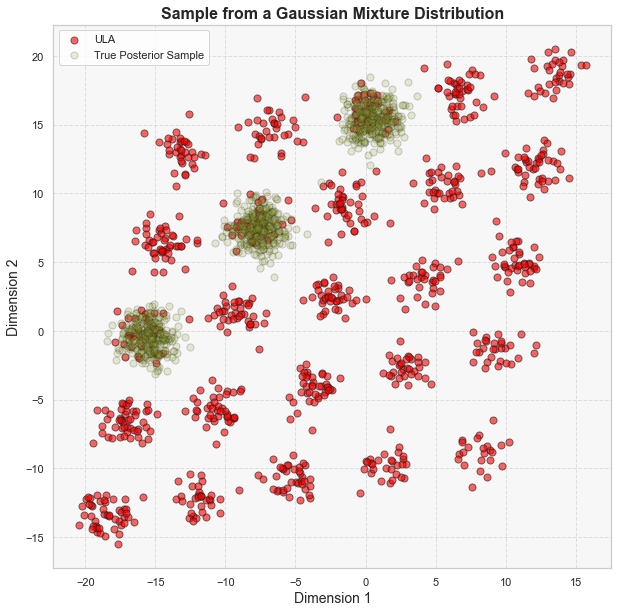

array([[  6.28382286,  18.03015638,   6.92952617, ...,  16.50273412,
          8.0970947 ,  18.59535768],
       [ -4.17188089,  -4.52567682,  -3.66911395, ...,  -3.11982831,
         -2.25760838,  -5.28799977],
       [-18.42133695,  -6.44220904, -17.97088075, ...,  -6.197364  ,
        -17.99820546,  -6.03250088],
       ...,
       [  5.90705821,  11.32310309,   5.74371394, ...,  10.04228664,
          6.12150888,   8.48916182],
       [ -2.64678092,  -4.3261205 ,  -4.00100285, ...,  -3.58789563,
         -2.57585056,  -6.42815956],
       [  9.77046331,  -9.80502618,   8.93116735, ...,  -9.91812812,
          8.26135091,  -6.62253594]])

In [697]:
sample_init = sample_prior_dx(1000, params[0], params[1], params[2])

ULA_post_dx(sample_init, 0.0000001, 500, params[0], params[1], params[2], y_obs_dx, 0.1, theta_star, True)

------------------------------------------------------------------------------------------------------------------------------------------
Comparison ULA vs ULA with Dilation Path to sample from the posterior distribution knowing $\theta^*$ :  

In [698]:
x_star = sample_prior_dx(1, params[0], params[1], params[2])
theta_star_list = [np.random.uniform(0, 1, 80), np.tile([-1, 0], 40), np.tile([-1, 1], 40), np.tile([3, 2], 40)]

y_obs_list = []

for i in range(len(theta_star_list)): 
    
    y_obs_list.append(generate_obs_dx(x_star, theta_star_list[i], 0.1))  ## generation of observation from the true_theta


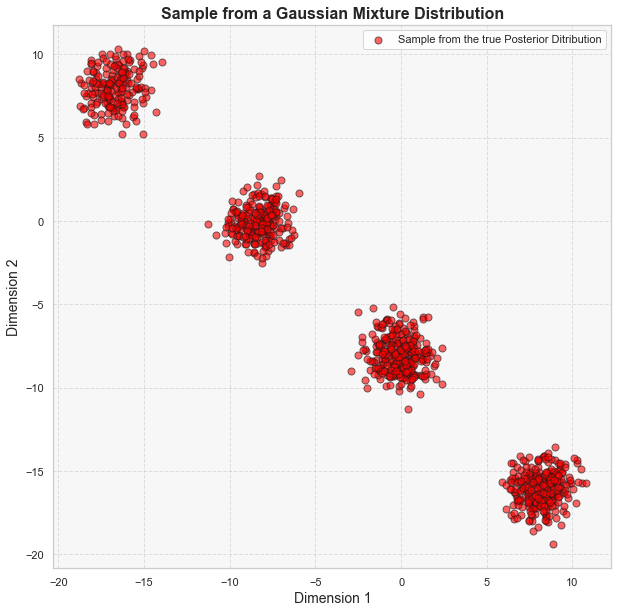

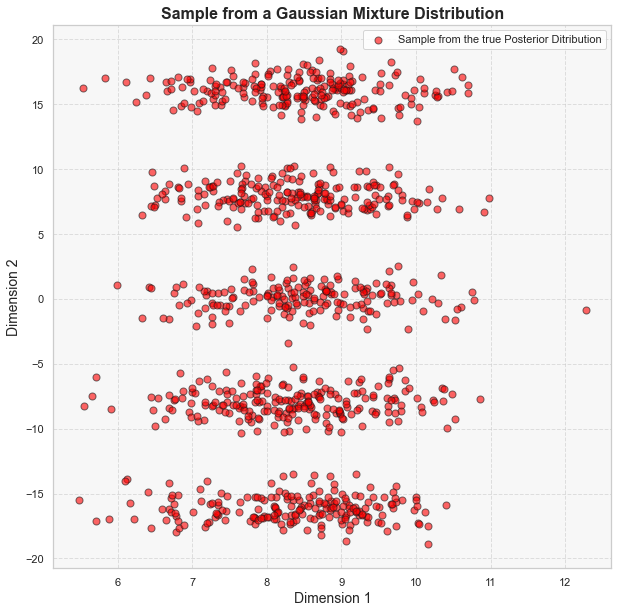

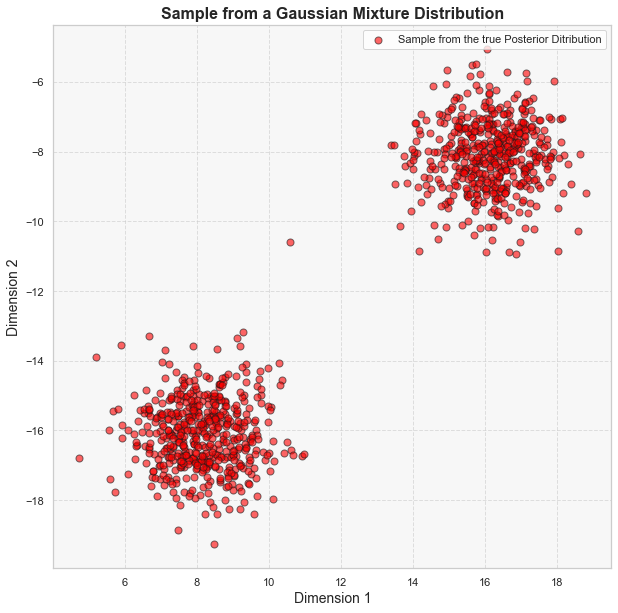

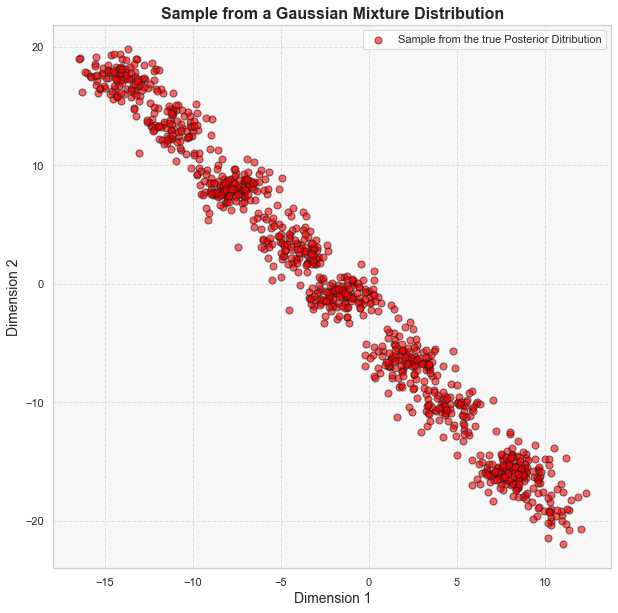

In [699]:
for i in range(len(theta_star_list)):

    centers_posteriori, covariances_posteriori, weights_posteriori = post_params_dx(theta_star_list[i], 0.1, means_prior, covariances_prior, weights_prior, y_obs_list[i])

    sample_post = sample_prior_dx(1000, centers_posteriori, covariances_posteriori, weights_posteriori)

    plot_sample_dx(sample_post, f'Sample from the true Posterior Ditribution')

  0%|          | 1/1000 [00:00<03:46,  4.41it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/Interacting Particles - MMLE/experiment_functions.py:124: RuntimeWarning: divide by zero encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/Interacting Particles - MMLE/experiment_functions.py:124: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
100%|██████████| 1000/1000 [04:31<00:00,  3.68it/s]


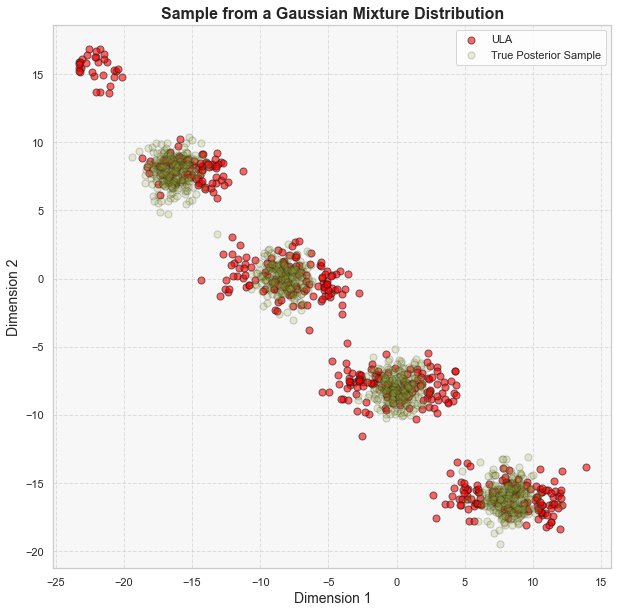

509


100%|██████████| 1000/1000 [04:22<00:00,  3.80it/s]


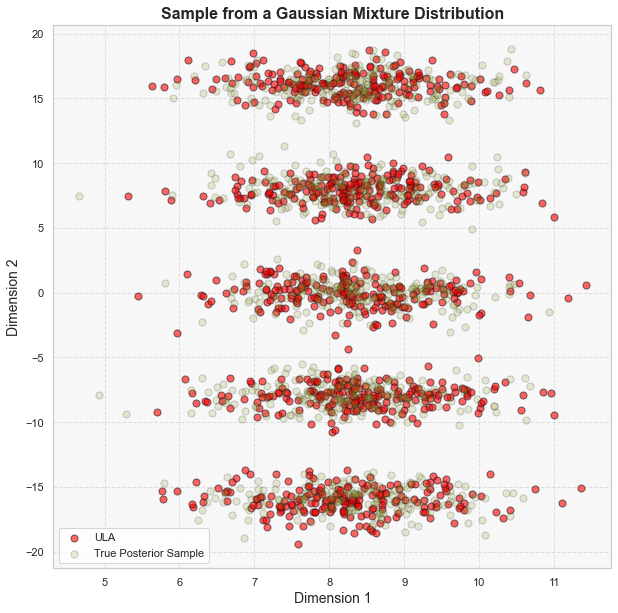

0


100%|██████████| 1000/1000 [05:41<00:00,  2.92it/s]


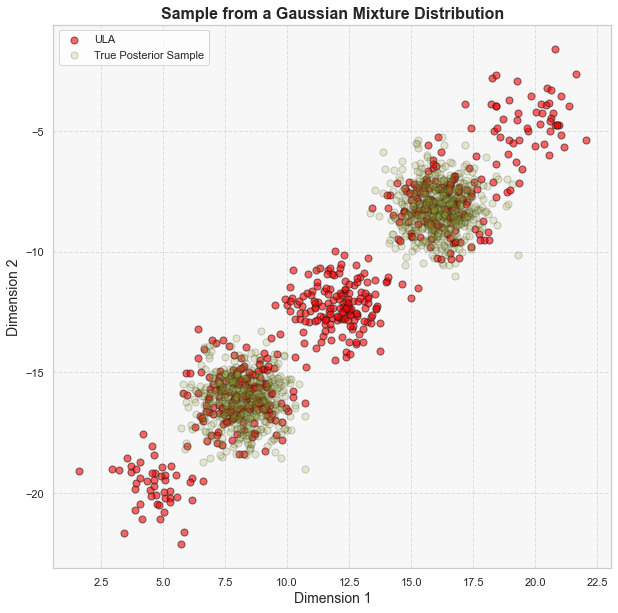

414


100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s]


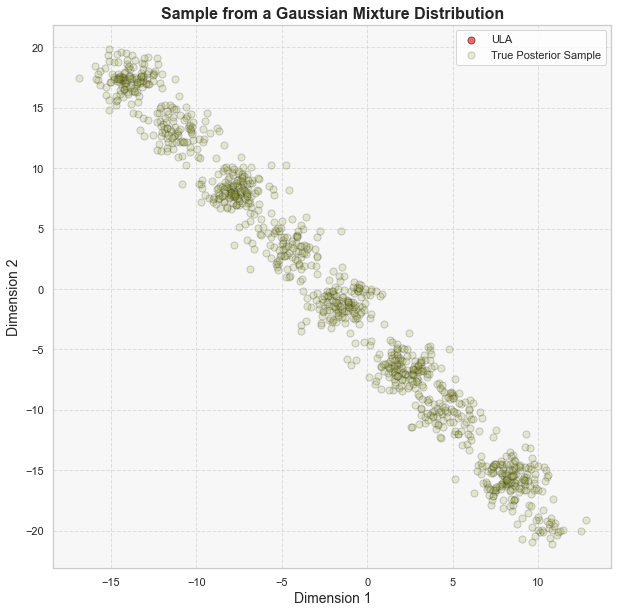

1000


In [702]:
for i in range(len(theta_star_list)) : 

    sample_init = sample_prior_dx(1000, means_prior, covariances_prior, weights_prior)
    traj = ULA_post_dx(sample_init, 0.0001, 1000, params[0], params[1], params[2], y_obs_list[i], 0.1, theta_star_list[i], True)
    print(np.sum(np.isnan(traj)) // 80)

------------------------------------------------------------------------------------------------------------------------------------------
TESTS NOT PART OF THE NOTEBOOK : 

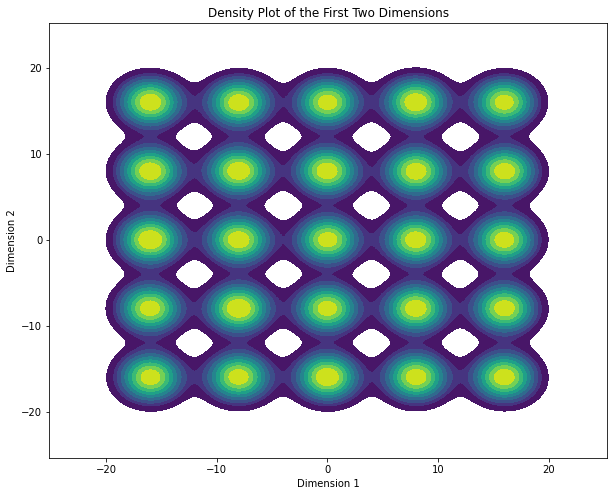

In [ ]:
samples_2d = x_start

# Plot the density using seaborn
plt.figure(figsize=(10, 8))
sns.kdeplot(x=samples_2d[:, 0], y=samples_2d[:, 1], fill=True, cmap="viridis")
plt.title("Density Plot of the First Two Dimensions")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

No handles with labels found to put in legend.


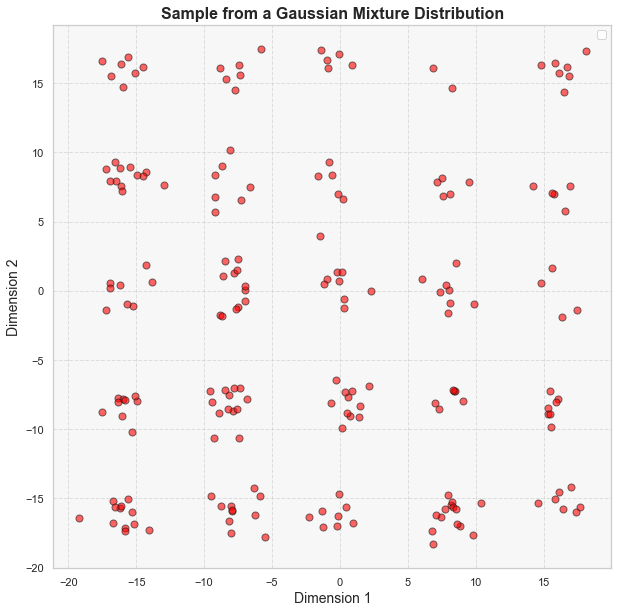

In [ ]:
sample_init = sample_prior_dx(200, means_prior, covariances_prior, weights_prior) 
plot_sample_dx(sample_init)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:02<00:00, 15.99it/s]


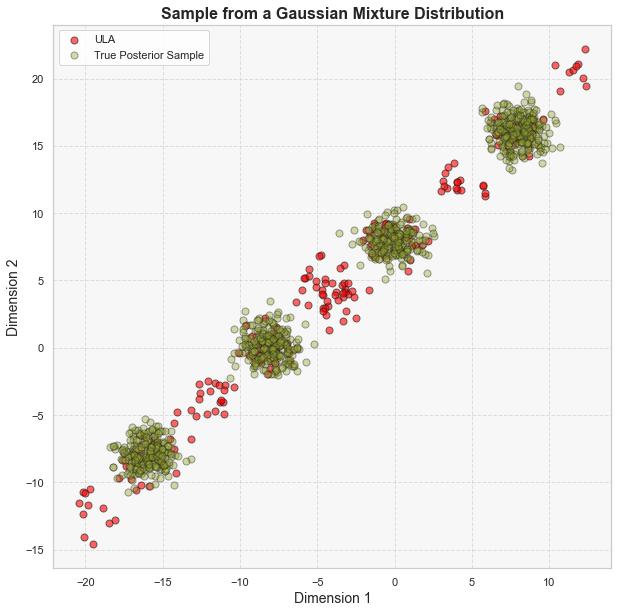

0

In [ ]:
traj = ULA_post_dx(sample_init, 0.000001, 1000, params[0], params[1], params[2], y_obs_list[i], 0.1, theta_star_list[i], True)
np.sum(np.isnan(traj)) // 80

In [706]:
def grad_multimodal_opti_precision(x, weights, centers, covariances): 
    
    n_components = len(weights)

    gradient = np.zeros(x.shape)

    covariance = covariances[0] #Warning : we assume that all the covariances are the same

    cov_inv = np.linalg.inv(covariance)

    pdf_tot = np.zeros(x.shape[0])

    for i in range(n_components):
        center = centers[i]
        weight = weights[i]

        center = torch.from_numpy(center)
        covariance = torch.from_numpy(covariance)

        dist = MultivariateNormal(center, covariance)

        pdf = torch.exp(dist.log_prob(x))
        # pdf = multivariate_normal.pdf(x, mean = center, cov = covariance)

        #if np.sum(np.isnan(pdf)) != 0 :
        
         #   print(f'pdf step{np.sum(np.isnan(pdf))}') 

        pdf_tot += pdf * weight #Denominator term
            
        diff = x - center

        gradient += weight * (np.einsum('ij,kj->ik', cov_inv, diff).T * pdf[:, np.newaxis]) #Numerator term

        #if np.sum(np.isnan(gradient)) != 0 :
         #   print(f'grad step{np.sum(np.isnan(gradient))}')

    #pdf_tot = np.maximum(pdf_tot, 1e-300) -> ce terme permet d'éviter les NaN mais fausse gravement les résultats
    
    gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
    
    #if np.sum(np.isnan(gradient)) != 0 : 
    #    print(f'final step{np.sum(np.isnan(gradient))}')

    return gradient


In [718]:
multivariate_normal.pdf(np.array([-10, 10]*40), mean = params[0], cov = params[1])

ValueError: Array 'mean' must be a vector of length 2000.

In [707]:
def ULA_post_dx_precision(sample_init, step_size, nb_iter, centers_prior, covariances_prior, weights_prior, y_obs, sigma_y, true_theta, plot = True): 

    sample_size = sample_init.shape[0]
    dim_var = sample_init.shape[1]

    traj = np.zeros((nb_iter, sample_size, dim_var))

    for i in tqdm(range(nb_iter)): 
        
        #grad = grad_multimodal_opti(sample_init, weights_test, centers_test, covariances_test)
        grad = ((1/sigma_y**2) * true_theta[:, np.newaxis] * (y_obs - np.dot(true_theta, sample_init.T))).T 

        grad += grad_multimodal_opti_precision(sample_init, weights_prior, centers_prior, covariances_prior)
        #grad += np.nan_to_num(grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior), nan = 0)

        sample_init += step_size * grad + np.sqrt(step_size * 2) * np.random.randn(sample_size, dim_var)

        traj[i] = sample_init

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample_init, "ULA", sample_post, "True Posterior Sample") 

    return sample_init


In [ ]:
traj_precision = ULA_post_dx_precision(sample_init, 0.001, 300, means_prior, covariances_prior, weights_prior, y_obs_list[0], 0.1, theta_star_list[0], True)

print(f'Nombre NaN normal {np.sum(np.isnan(traj))//80}')
print(f'Nombre NaN precision {np.sum(np.isnan(traj_precision))//80}')

100%|██████████| 300/300 [01:23<00:00,  3.59it/s]


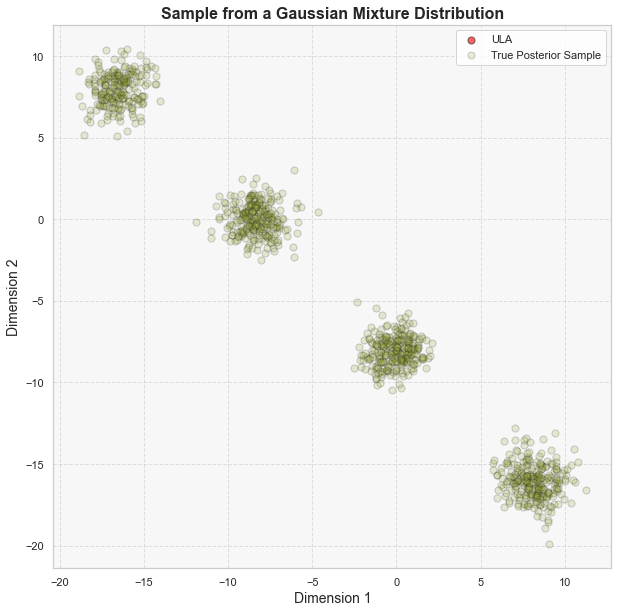

In [709]:

traj = ULA_post_dx(sample_init, 0.0001, 300, means_prior, covariances_prior, weights_prior, y_obs_list[0], 0.1, theta_star_list[0], True)

In [ ]:
sample_init_2 = np.zeros((20, 80))

for i in range(20): 

    sample_init_2[i] = np.random.uniform(-20, 20, 80)

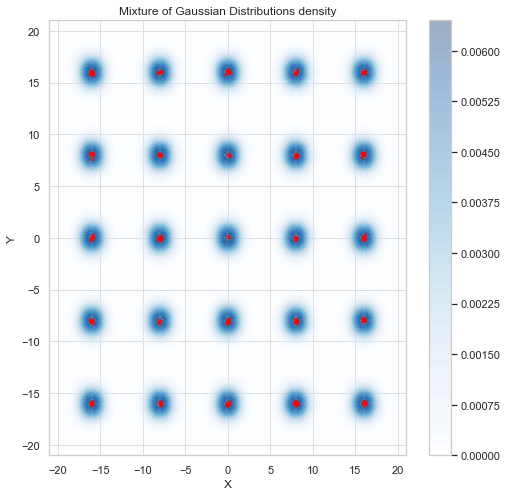

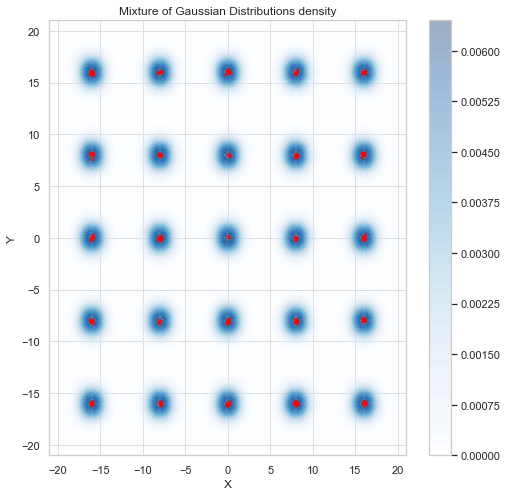

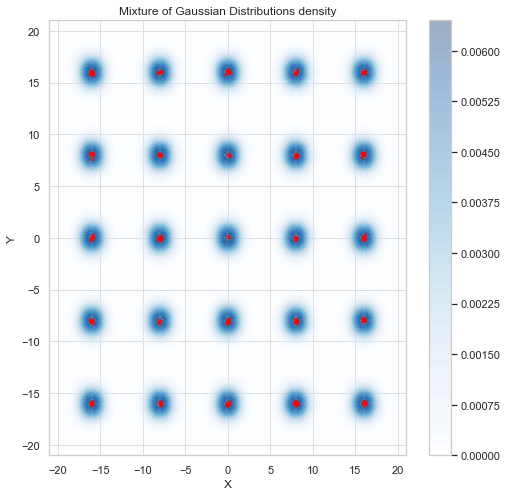

In [ ]:
generate_multimodal(centers_prior_2, covariances_prior_2, weights_prior_2, traj)
generate_multimodal(centers_prior_2, covariances_prior_2, weights_prior_2, traj_2)
generate_multimodal(centers_prior_2, covariances_prior_2, weights_prior_2, traj_3)

In [688]:
def grad_multimodal_opti_NaN(x, weights, centers, covariances): 
    
    n_components = len(weights)

    gradient = np.zeros(x.shape)

    covariance = covariances[0] #Warning : we assume that all the covariances are the same

    cov_inv = np.linalg.inv(covariance)

    pdf_tot = np.zeros(x.shape[0])

    for i in range(n_components):
        center = centers[i]
        weight = weights[i]

        logpdf = multivariate_normal.logpdf(x, mean = center, cov = covariance)

        #if np.sum(np.isnan(pdf)) != 0 :
        
        #   print(f'pdf step{np.sum(np.isnan(pdf))}') 

        pdf_tot += np.exp(logpdf + np.log(weight)) #Denominator term
            
        diff = x - center

        gradient += (np.einsum('ij,kj->ik', cov_inv, diff).T) * np.exp(np.log(weight) + logpdf[:, np.newaxis]) #Numerator term

    #pdf_tot = np.maximum(pdf_tot, 1e-300) -> ce terme permet d'éviter les NaN mais fausse gravement les résultats
    
    gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])

    return gradient


In [689]:
def ULA_post_dx_test(sample_init, step_size, nb_iter, centers_prior, covariances_prior, weights_prior, y_obs, sigma_y, true_theta, plot = True): 

    sample_size = sample_init.shape[0]
    dim_var = sample_init.shape[1]

    traj = np.zeros((nb_iter, sample_size, dim_var))

    grad = np.zeros((sample_size, dim_var))

    for i in tqdm(range(nb_iter)): 
        
        #grad = grad_multimodal_opti(sample_init, weights_test, centers_test, covariances_test)
        #grad = ((1/sigma_y**2) * true_theta[:, np.newaxis] * (y_obs - np.dot(true_theta, sample_init.T))).T 

        grad += grad_multimodal_opti_NaN(sample_init, weights_prior, centers_prior, covariances_prior)
        #grad += np.nan_to_num(grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior), nan = 0)

        sample_init += step_size * grad #+ np.sqrt(step_size * 2) * np.random.randn(sample_size, dim_var)

        traj[i] = sample_init

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample_init, "ULA", sample_post, "True Posterior Sample") 

    return sample_init


In [690]:
#We define the grid

x = np.linspace(-16, 16, 5)
y = np.linspace(-16, 16, 5)

xx, yy = np.meshgrid(x, y)


## We define the parameters of the target Gaussian Mixture

# We define the centers for each mode
centers_prior_2 = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix and the weights : 

covariances_prior_2 = np.array([[[1, 0], [0, 1]]]*25)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights_prior_2 = np.ones(25) / 25


# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)

sample_init_2 = np.random.randn(20, 2) * 15


## Other parameters : 

nb_particles = 1000

step_size = 0.001

nb_iter = 10000

##Dimensions des variables

dx = 2

dy = 1

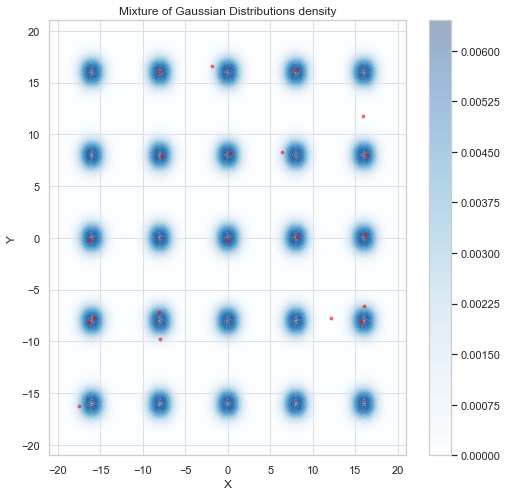

In [695]:
generate_multimodal(centers_prior_2, covariances_prior_2, weights_prior_2, traj_test)

100%|██████████| 5000/5000 [00:40<00:00, 123.94it/s]


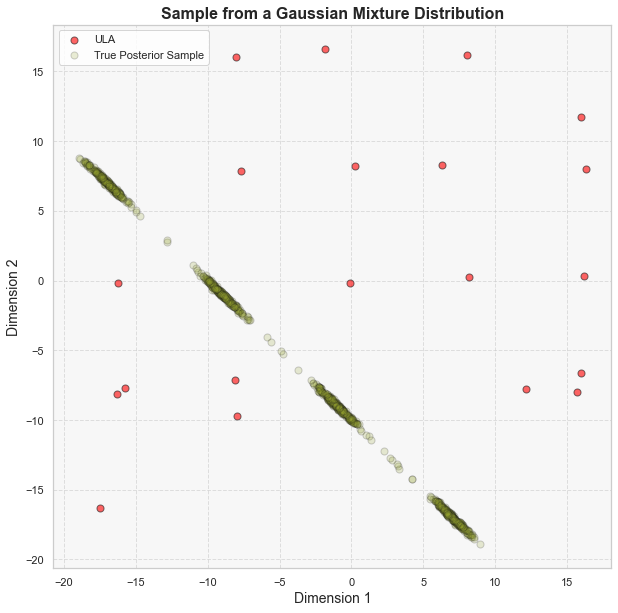

In [693]:
traj_test = ULA_post_dx_test(sample_init_2, 0.01, 5000, centers_prior_2, covariances_prior_2, weights_prior_2, np.array(-10), 0.1, np.array([1, 1]), True)